In [1]:
# Importa Pandas, Numpy, Seaborn y Matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Importar el archivo "Online Retail.csv"
df= pd.read_csv("M30 Online Retail.csv", encoding='ISO-8859-1')
print(df.head())

  INVOICE_NO STOCK_CODE                          DESCRIPTION  QUANTITY  \
0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365      71053                  WHITE METAL LANTERN         6   
2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

       INVOICE_DATE  UNIT_PRICE  CUSTOMER_ID          REGION  
0  01/12/2019 08:26        2.55      17850.0  United Kingdom  
1  01/12/2019 08:26        3.39      17850.0  United Kingdom  
2  01/12/2019 08:26        2.75      17850.0  United Kingdom  
3  01/12/2019 08:26        3.39      17850.0  United Kingdom  
4  01/12/2019 08:26        3.39      17850.0  United Kingdom  


In [6]:
# Análisis Exploratorio
df_info = df.info()
df_head = df.head()
df_description = df.describe(include="all")
df_nulls = df.isnull().sum()

df_info, df_head, df_description, df_nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


(None,
   INVOICE_NO STOCK_CODE                          DESCRIPTION  QUANTITY  \
 0     536365     85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1     536365      71053                  WHITE METAL LANTERN         6   
 2     536365     84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3     536365     84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4     536365     84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 
        INVOICE_DATE  UNIT_PRICE  CUSTOMER_ID          REGION  
 0  01/12/2019 08:26        2.55      17850.0  United Kingdom  
 1  01/12/2019 08:26        3.39      17850.0  United Kingdom  
 2  01/12/2019 08:26        2.75      17850.0  United Kingdom  
 3  01/12/2019 08:26        3.39      17850.0  United Kingdom  
 4  01/12/2019 08:26        3.39      17850.0  United Kingdom  ,
        INVOICE_NO STOCK_CODE                         DESCRIPTION  \
 count      541909     541909                              540455   
 unique      25900

## Recency

In [8]:
# Obtener los clientes unicos
customer = df['CUSTOMER_ID'].dropna().unique()
print(f"Número de clientes únicos: {len(customer)}")

Número de clientes únicos: 4372


In [10]:
# Obtener la última fecha de compra por cliente
df['INVOICE_DATE'] = pd.to_datetime(df['INVOICE_DATE'], dayfirst=True)
max_purchase = df.groupby('CUSTOMER_ID')['INVOICE_DATE'].max()
print(max_purchase.head())

CUSTOMER_ID
12346.0   2020-01-18 10:17:00
12347.0   2020-12-07 15:52:00
12348.0   2020-09-25 13:13:00
12349.0   2020-11-21 09:51:00
12350.0   2020-02-02 16:01:00
Name: INVOICE_DATE, dtype: datetime64[ns]


In [15]:
# Calcular nuestra metrica de Recency, esto lo haremos restando los días de la última fecha de compra a cada observacón
last_date = df['INVOICE_DATE'].max()
max_purchase = df.groupby('CUSTOMER_ID')['INVOICE_DATE'].max().reset_index()
max_purchase['RECENCY'] = (last_date - max_purchase['INVOICE_DATE']).dt.days

In [17]:
# Unir el DataFrame de clientes únicos con el que acabamos de crear de la última fecha de compra
customer_unique = df[['CUSTOMER_ID']].drop_duplicates()
customer = pd.merge(customer_unique, max_purchase, on='CUSTOMER_ID')

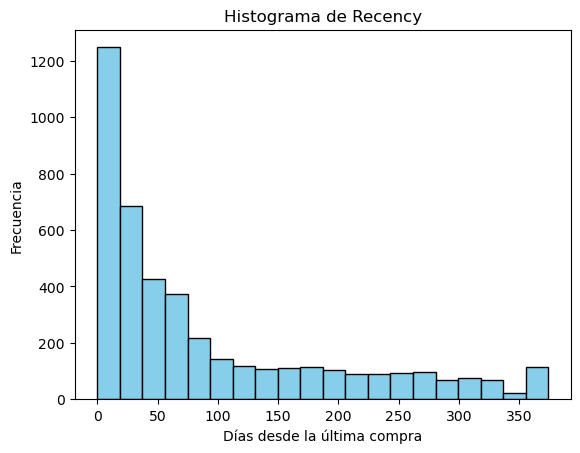

In [19]:
# Grafica un histograma de Recency
plt.hist(customer['RECENCY'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de Recency')
plt.xlabel('Días desde la última compra')
plt.ylabel('Frecuencia')
plt.show()

In [21]:
# Imprime la Estadística de Resumen para Recency
print(customer['RECENCY'].describe())

count    4372.000000
mean       91.123056
std       100.946554
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       374.000000
Name: RECENCY, dtype: float64


## Frequency

In [24]:
# Obtener el número de compras por cliente
frequency = df.groupby('CUSTOMER_ID')['INVOICE_NO'].nunique()

In [26]:
# Unir el DataFrame que acabamos de crear con el de los clientes unicos
customer = customer.merge(frequency.rename('FREQUENCY'), on='CUSTOMER_ID', how='left')

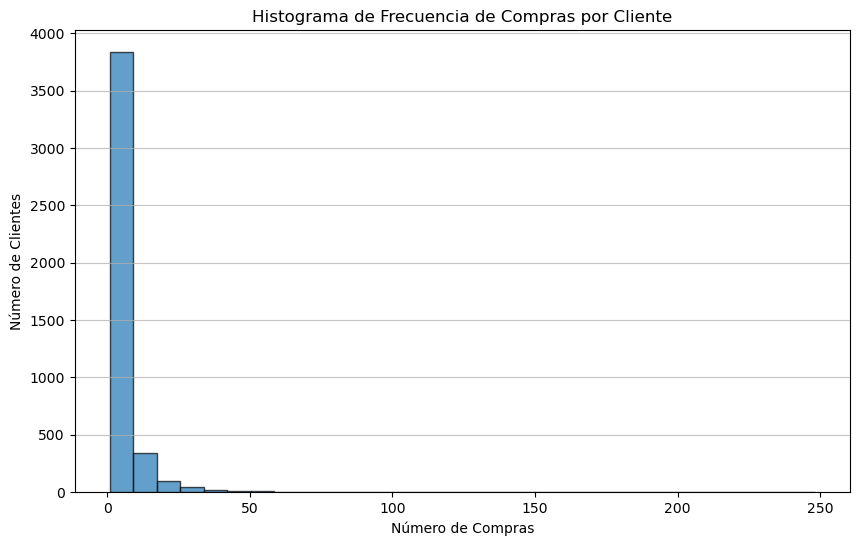

In [28]:
# Grafica un histograma de Frequency
plt.figure(figsize=(10, 6))
plt.hist(customer['FREQUENCY'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma de Frecuencia de Compras por Cliente')
plt.xlabel('Número de Compras')
plt.ylabel('Número de Clientes')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [30]:
# Impricion de Estadística de Resumen para Frequency
print(customer['FREQUENCY'].describe())

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: FREQUENCY, dtype: float64


## Monetary
<p>Valor del monto total que ha gastado un cliente en la compra de mis productos</p>

In [32]:
# Calcular el monto total por cada compra
df['MONETARY'] = df['QUANTITY'] * df['UNIT_PRICE']

# Obtener el valor monetario de compra por cliente
monetary = df.groupby('CUSTOMER_ID')['MONETARY'].sum()

In [34]:
# Unir el DataFrame que acabamos de crear con el de los clientes unicos
customer = customer.merge(monetary.rename('MONETARY'), on='CUSTOMER_ID', how='left')

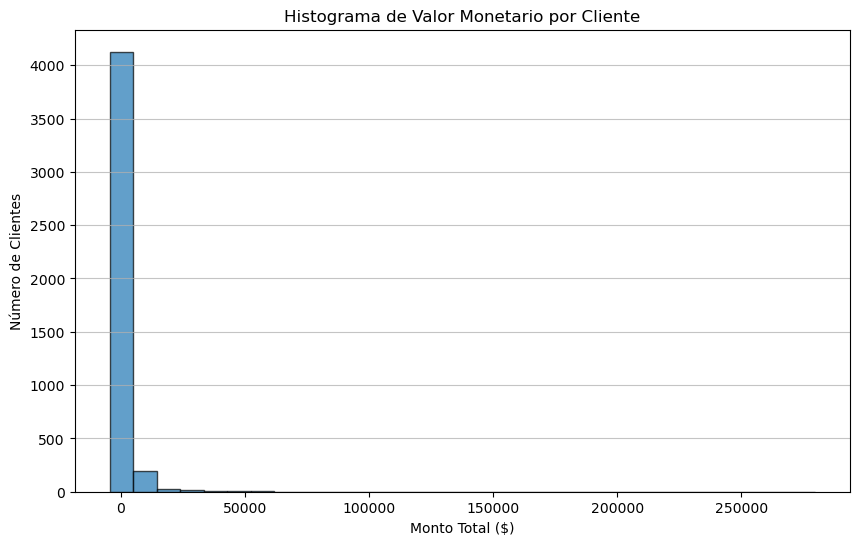

In [36]:
# Grafica un histograma de Monetary
plt.figure(figsize=(10, 6))
plt.hist(customer['MONETARY'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma de Valor Monetario por Cliente')
plt.xlabel('Monto Total ($)')
plt.ylabel('Número de Clientes')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [37]:
# Imprime la Estadística de Resumen para Monetary
print(customer['MONETARY'].describe())

count      4372.000000
mean       1898.459701
std        8219.345141
min       -4287.630000
25%         293.362500
50%         648.075000
75%        1611.725000
max      279489.020000
Name: MONETARY, dtype: float64


## Algoritmo k-Means
<p>Ya creamos nuestros indicadores principales de la metodología RFM. es hora de hacer <i>Machine Learning</i>. Para ello utilizaremos un algoritmo no supervisado llamado <b>k-Means</b></p>


In [40]:
# Funcion para ordenar los clusters
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

## Elbow Method

In [42]:
# Importa la librería de kMeans
from sklearn.cluster import KMeans

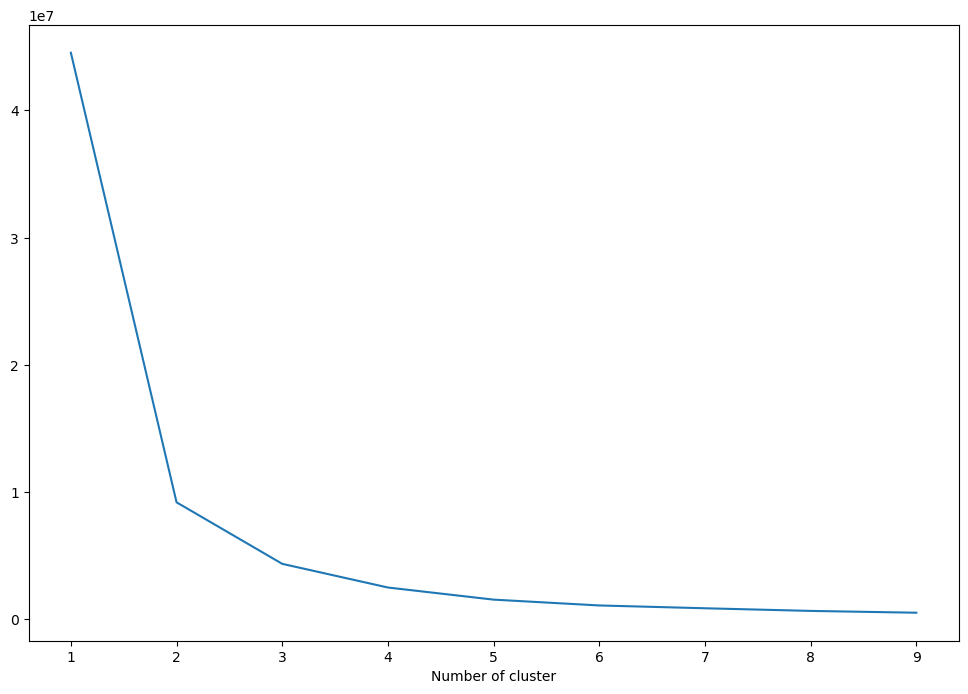

In [44]:
# Configuración inicial - Vamos a tomar como referencia el indicador de Recency
sse = {}
recency = max_purchase.reset_index()[['CUSTOMER_ID', 'INVOICE_DATE']]  
recency.columns = ['CUSTOMER_ID', 'Recency']  
recency['Recency'] = (last_date - recency['Recency']).dt.days  
recency = recency[['Recency']] 

for k in range(1, 10):
    # Instancia el algoritmo de k-means iterando sobre k
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Entrena el algoritmo
    kmeans.fit(recency)
    
    # Adjunta las etiquetas
    recency["clusters"] = kmeans.labels_
    
    # Adunta la inercia o variación al arreglo sse
    sse[k] = kmeans.inertia_
    
# Grafico de codo (Elbow)
plt.figure(figsize=(12,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [47]:
# Instanciar el algoritmo con 4 clusters para Recency 
kmeans = KMeans(n_clusters=4, random_state=42)

# Entrenar el algoritmo
kmeans.fit(customer[['RECENCY']])

# Obtener las predicciones
customer['RECENCY_CLUSTER'] = kmeans.labels_

# Ordenar los clusters
customer = order_cluster('RECENCY_CLUSTER', 'RECENCY', customer, False)

# Estadística Descriptiva del cluster creado
customer.groupby('RECENCY_CLUSTER')['RECENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
RECENCY_CLUSTER,,,,,,,,
0,528.0,306.907197,40.650555,246.0,269.0,303.0,338.0,374.0
1,628.0,185.367834,32.666602,132.0,156.0,184.0,213.0,245.0
2,1059.0,77.814920,22.830097,48.0,59.0,73.0,93.5,131.0
3,2157.0,17.397311,13.188805,0.0,6.0,16.0,28.0,47.0


In [49]:
# Instanciar el algoritmo con 4 clusters para Frequency 
kmeans = KMeans(n_clusters=4, random_state=42)

# Entrenar el algoritmo
kmeans.fit(customer[['FREQUENCY']])

# Obtener las predicciones
customer['FREQUENCY_CLUSTER'] = kmeans.labels_

# Ordenar los clusters
customer = order_cluster('FREQUENCY_CLUSTER', 'FREQUENCY', customer, True)

# Estadística Descriptiva de los clusters
customer.groupby('FREQUENCY_CLUSTER')['FREQUENCY'].describe()

,count,mean,std,min,25%,50%,75%,max
FREQUENCY_CLUSTER,,,,,,,,
0,3835.0,2.945502,2.146658,1.0,1.0,2.0,4.00,9.0
1,494.0,16.032389,6.247349,10.0,11.0,14.0,19.00,36.0
2,40.0,58.325000,22.847754,38.0,43.0,51.5,63.75,128.0
3,3.0,213.666667,40.501029,169.0,196.5,224.0,236.00,248.0


In [51]:
# Instanciar el algoritmo con 4 clusters para Monetary 
kmeans = KMeans(n_clusters=4, random_state=42)

# Entrenar el algoritmo
kmeans.fit(customer[['MONETARY']])

# Obtener las predicciones
customer['MONETARY_CLUSTER'] = kmeans.labels_

# Ordenar los clusters ¿Como tienes que ordenar el cluster?
customer = order_cluster('MONETARY_CLUSTER', 'MONETARY', customer, True)

# Estadística Descriptiva de los clusters
customer.groupby('MONETARY_CLUSTER')['MONETARY'].describe()

,count,mean,std,min,25%,50%,75%,max
MONETARY_CLUSTER,,,,,,,,
0,4329.0,1347.622983,1994.067733,-4287.63,291.0000,640.500,1550.8500,17588.26
1,36.0,35694.129167,14720.254051,18573.68,24695.2375,30800.450,50894.9825,65892.08
2,4.0,114451.897500,19223.119671,88125.38,107069.4500,118554.795,125937.2425,132572.62
3,3.0,241136.560000,47874.073443,187482.17,221960.3300,256438.490,267963.7550,279489.02


## Score de Segmentación
El algoritmo de k-means nos da una segmentación generalizada, pero podemos personalizarla aún más creando una métrica que asigne una calificación al valor del cluster. Esto es lo que vamos a hacer

In [54]:
# Vamos a crear nuestro score sumando el valor de cada uno de los clusters
customer['SCORE'] = customer['RECENCY_CLUSTER'] + customer['FREQUENCY_CLUSTER'] + customer['MONETARY_CLUSTER']

# Obtener el promedio para cada una de las métricas de las calificaciones creadas (Score)
customer.groupby('SCORE')[['RECENCY', 'FREQUENCY', 'MONETARY']].mean()

,RECENCY,FREQUENCY,MONETARY
SCORE,,,
0,307.078095,1.430476,333.779790
1,185.861958,2.216693,551.810772
2,78.916667,2.872093,940.810457
3,20.415294,3.988235,1236.020806
4,11.421296,16.085648,4791.754074
5,5.264706,39.058824,21311.680882
6,5.611111,60.555556,43742.330000
7,3.000000,126.250000,67730.600000
8,2.000000,110.500000,213995.575000


In [56]:
# Creacion de una funcion que asigne lo siguiente: 
# Si score <= 1 entonces 'Low-Value', si score >1 y <=4 entonces 'Average', si score >4 y <=6 entonces 'Potential', por último si score >6 entonces 'High-Value'
def segment(score):
    if score <= 1:
        return 'Low-Value'
    elif score > 1 and score <= 4:
        return 'Average'
    elif score > 4 and score <= 6:
        return 'Potential'
    else:  # Si score > 6
        return 'High-Value'
# Crear una columna aplicando esta función al campo 'SCORE'
customer['SEGMENT'] = customer['SCORE'].apply(segment)

In [58]:
# Vamos a dar un vistazo a la tabla final
customer.head()

,CUSTOMER_ID,INVOICE_DATE,RECENCY,FREQUENCY,MONETARY,RECENCY_CLUSTER,FREQUENCY_CLUSTER,MONETARY_CLUSTER,SCORE,SEGMENT
0,17850.0,2020-02-10 14:38:00,302,35,5288.63,0,1,0,1,Low-Value
1,13047.0,2020-11-08 12:10:00,31,18,3079.10,3,1,0,4,Average
2,12583.0,2020-12-07 08:07:00,2,18,7187.34,3,1,0,4,Average
3,13748.0,2020-09-05 09:45:00,95,5,948.25,2,0,0,2,Average
4,15100.0,2020-01-13 17:09:00,330,6,635.10,0,0,0,0,Low-Value


In [60]:
print(customer['SEGMENT'].value_counts())

SEGMENT
Average       3164
Low-Value     1148
Potential       52
High-Value       8
Name: count, dtype: int64


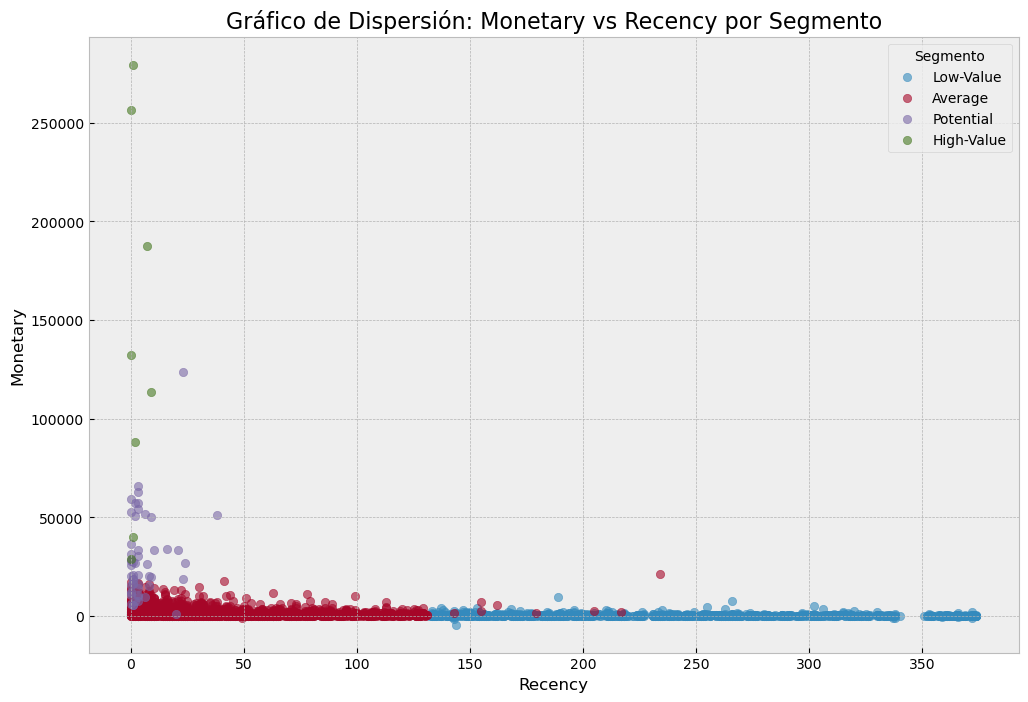

In [62]:
plt.style.use('bmh')
# Filtracion de valores para RECENCY < 4000
filtered_data = customer[customer['RECENCY'] < 4000]
# Creacion de grafico de dispersion de 'MONETARY' VS 'RECENCY' por Segmento
plt.figure(figsize=(12, 8))
for segment in filtered_data['SEGMENT'].unique():
    segment_data = filtered_data[filtered_data['SEGMENT'] == segment]
    plt.scatter(segment_data['RECENCY'], segment_data['MONETARY'], label=segment, alpha=0.6)

plt.title('Gráfico de Dispersión: Monetary vs Recency por Segmento', fontsize=16)
plt.xlabel('Recency', fontsize=12)
plt.ylabel('Monetary', fontsize=12)
plt.legend(title='Segmento')
plt.show()


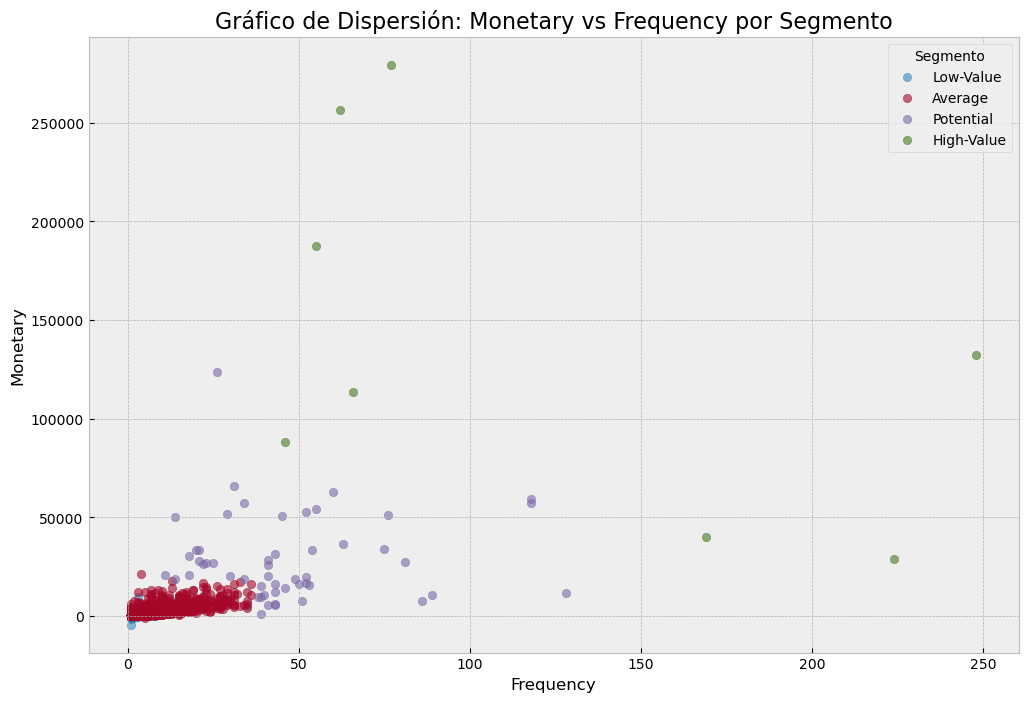

In [61]:
# Crea un grafico de dispersion de 'MONETARY' vs 'FREQUENCY' vs  por Segmento
plt.figure(figsize=(12, 8))
for segment in customer['SEGMENT'].unique():
    segment_data = customer[customer['SEGMENT'] == segment]
    plt.scatter(segment_data['FREQUENCY'], segment_data['MONETARY'], label=segment, alpha=0.6)

# Etiquetas y leyenda
plt.title('Gráfico de Dispersión: Monetary vs Frequency por Segmento', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Monetary', fontsize=12)
plt.legend(title='Segmento')
plt.show()




# Conclusiones

* En este análisis, se aplicaron técnicas de aprendizaje no supervisado, específicamente clustering, para segmentar a los clientes en función de tres métricas clave: Recency, Frequency y Monetary. El objetivo fue identificar patrones de comportamiento entre los clientes y asignarlos a segmentos específicos que permitan acciones estratégicas personalizadas.

* Podremos tener hallazgos, que podrian dividirse en: La segmentacion de los clientes, graficos de dipersion y en las tendencias que se obvervaron.

* Para finalizaren este análisis proporciona una base sólida para la toma de decisiones estratégicas enfocadas en los comportamientos y necesidades específicas de cada segmento.